# Predicting invasive ductal carcinoma in tissue slices


## Motivation

Inasive ductal carcinoma (IDC) is - with ~ 80 % of cases - one of the most common types of breast cancer. It's malicious and able to form metastases which makes it especially dangerous. Often a biopsy is done to remove small tissue samples. Then a pathologist has to decide whether a patient has IDC, another type of breast cancer or is healthy. In addition sick cells need to be located to find out how advanced the disease is and which grade should be assigned. This has to be done manually and is a time consuming process. Furthermore the decision depends on the expertise of the pathologist and his or her equipment. Therefor deep learning could be of great help to automatically detect and locate tumor tissue cells and to speed up the process. In order to exploit the full potential one could build a pipeline using massive amounts of tissue image data of various hospitals that were evaluated by different experts. This way one would be able to overcome the dependence on the pathologist which would be especially useful in regions where no experts are available .      

## Our goal

As we started with this analysis we asked ourselves if we would be able to improve the results that were presented 2014 in the paper [Automatic detection of invasive ductal carcinoma in whole slide images with Convolutional Neural Networks](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.725.4294&rep=rep1&type=pdf) of professor [Anant Madabhushi](https://case.edu/medicine/ccir/faculty/anant-madabhushi) and his group. Many years have passed by since then and it's very likely that all methods used in the paper have already been changed, improved and that new research has already been done. Nonetheless it's a very good exercise to practice or develop own deep learning and data science skills.


## Methods presented in the paper

Collecting information... ;-)

* In the paper tissue slices of 162 patients were used all having IDC (113 used for training and 49 for validation)
* One pathologist was used to determine regions of IDC given a tissue slice 
* evaluation metric: F1 score and balanced accuracy


* Our goal: Given a patient and a patch of a tissue slice predict wheather it contains IDC or not.
    * 3 possibilities: healthy tissue, IDC, another subtype of breast cancer
* business case: prediction so far is done manually by pathologists and varies from expert to expert. The goal is to assist with an automatic detection of tumors (not expert dependent). 


## Table of contents

1. [What is meant by invasive ductal carcinoma?](#intro) 
2. [Preparation & peek at the data structure](#prep)
    * [Loading packages and settings](#setup)
    * [Exploring the data structure](#explorestructure)
3. [Exploratory analysis](#eda)
    * [What do we know about our data?](#data)
    * [Looking at healthy and invasive ductal carcinoma patches](#patches)
    * [Visualising the breast tissue](#tissue)
4. [Setting up the machine learning workflow](#workflow)
    * [Settings](#ml_settings)
    * [Validation strategy](#validation)
    * [Target distributions](#target_dists)
    * [Creating pytorch image datasets](#image_datasets)
    * [Creating pytorch dataloaders](#dataloaders)
    * [Defining the model structure](#model_structure)
    * [Setting up the loss function](#loss_eva)
    * [Selecting an evaluation metric](#e_metric)
    * [Building the training loop](#train_loop)
    * [Searching for an optimal cyclical learning rate](#lr_cycle_optima)
    * [Performing the training or loading results](#run)
5. [Exploring results and errors](#error_analysis)
    * [Loss convergence](#losses)
    * [The probability landscape of invasive ductal carcinoma](#landscape)
    * [Going into details](#details)
7. [Conclusion](#conclusion)


## What is meant by invasive ductal carcinoma? <a class="anchor" id="intro"></a>

<a title="Mikael Häggström, M.D. - Author info - Reusing images [CC BY (https://creativecommons.org/licenses/by/2.5)]" href="https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg"><img width="309" alt="Lobules and ducts of the breast" style="float:left; margin:0px 15px 15px 15px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Lobules_and_ducts_of_the_breast.jpg/256px-Lobules_and_ducts_of_the_breast.jpg"></a>


This illustration created [Mikael Häggström](https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg) shows the anatomy of a healthy breast. One can see the lobules, the glands that can produce milk which flews through the milk ducts. Ductal carcinoma starts to develop in the ducts whereas lobular carcinoma has its origin in the lobules. Invasive carcinoma is able to leave its initial tissue compartment and can form metastases. 

# Preparation & peek at the data structure <a class="anchor" id="prep"></a>

## Loading packages and setting <a class="anchor" id="setup"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

### Settings

In [2]:
run_training = False
retrain = False
find_learning_rate = False

## Exploring the data structure <a class="anchor" id="explorestructure"></a>

In [3]:
files = listdir("breast-histopathology-images/")
print(len(files))

280


In [4]:
files[0:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

Ok, in this folder we should find several images or a further substructure of folders.

In [5]:
files = listdir("breast-histopathology-images/IDC_regular_ps50_idx5/")
len(files)

279

Ah ok. These are patient ids. For each patient we have an individual subfolder that contains image patches. 

### How many patients do we have?

In [6]:
base_path = "breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

Almost 280 patients. That's a small number compared to the expected number of patients one would like to analyse with our algorithm after deployment. **Consequently overfitting to this specific patient distribution is very likely and we need to take care about the generalization performance of our model**. 

### How many patches do we have in total?

Our algorithm needs to decide whether an image patch contains IDC or not. Consequently not the whole patient tissue slice but the single patches have to be considered as input to our algorithm. How many of them do we have in total?

In [7]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [8]:
total_images

277524

Ok, roughly 280000 images. To feed the algorithm with image patches it would be nice to store the path of each image. This way we can load batches of images only one by one without storing the pixel values of all images. 

### Storing the image_path, patient_id and the target

In [9]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      10253  breast-histopathology-images/IDC_regular_ps50_...      0
1      10253  breast-histopathology-images/IDC_regular_ps50_...      0
2      10253  breast-histopathology-images/IDC_regular_ps50_...      0
3      10253  breast-histopathology-images/IDC_regular_ps50_...      0
4      10253  breast-histopathology-images/IDC_regular_ps50_...      0

Ok, now for each patient we know the path for each patch as well as if it contains IDC or not (the target).

In [10]:
data.shape

(277524, 3)

No surprise. This matches the total number of patches. 

# Exploratory analysis <a class="anchor" id="eda"></a>

## What do we know about our data? <a class="anchor" id="data"></a>

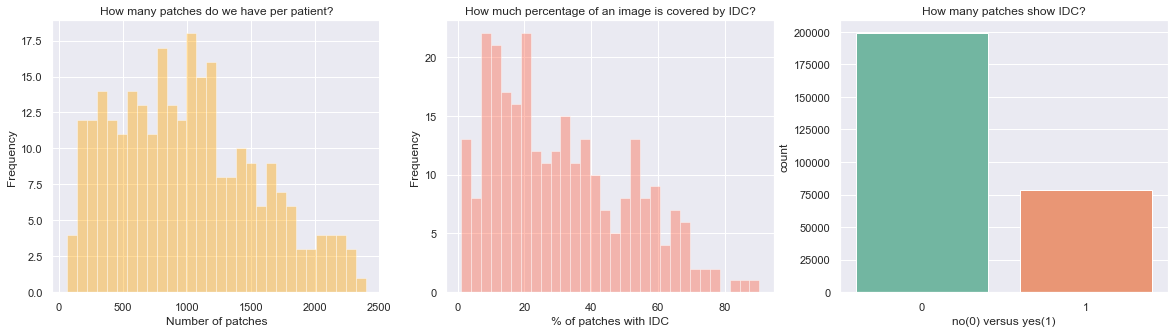

In [11]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Insights

1. The number of image patches per patient varies a lot! **This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients**. 
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. **Does a tissue slice per patient cover the whole region of interest?**
3. The **classes of IDC versus no IDC are imbalanced**. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

## Looking at healthy and cancer patches <a class="anchor" id="patches"></a>

In [12]:
data.target = data.target.astype(np.int)

In [13]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

### Cancer patches

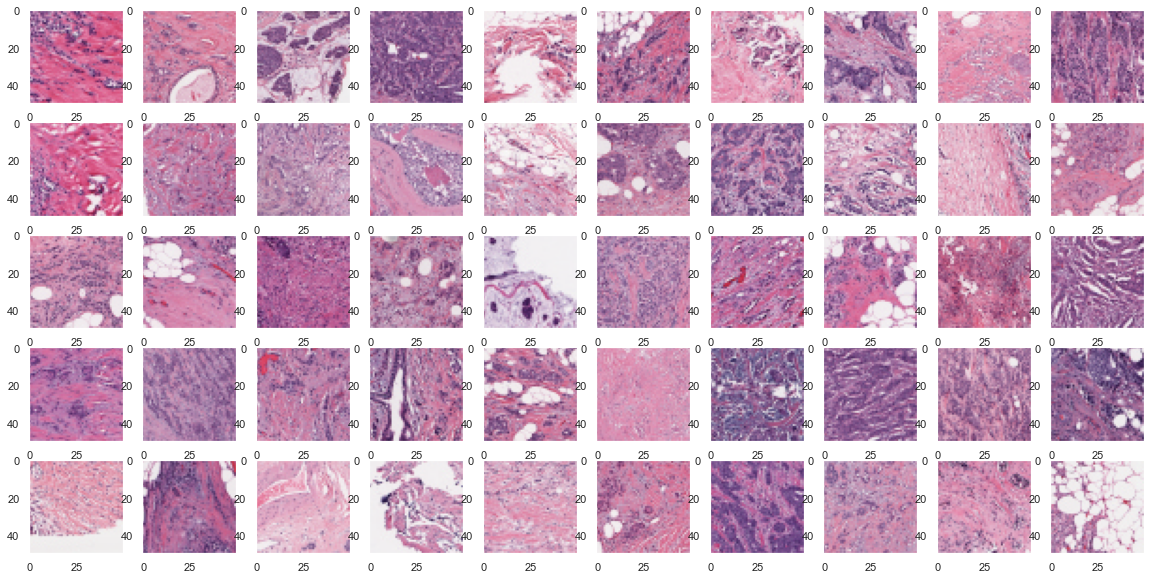

In [14]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy patches

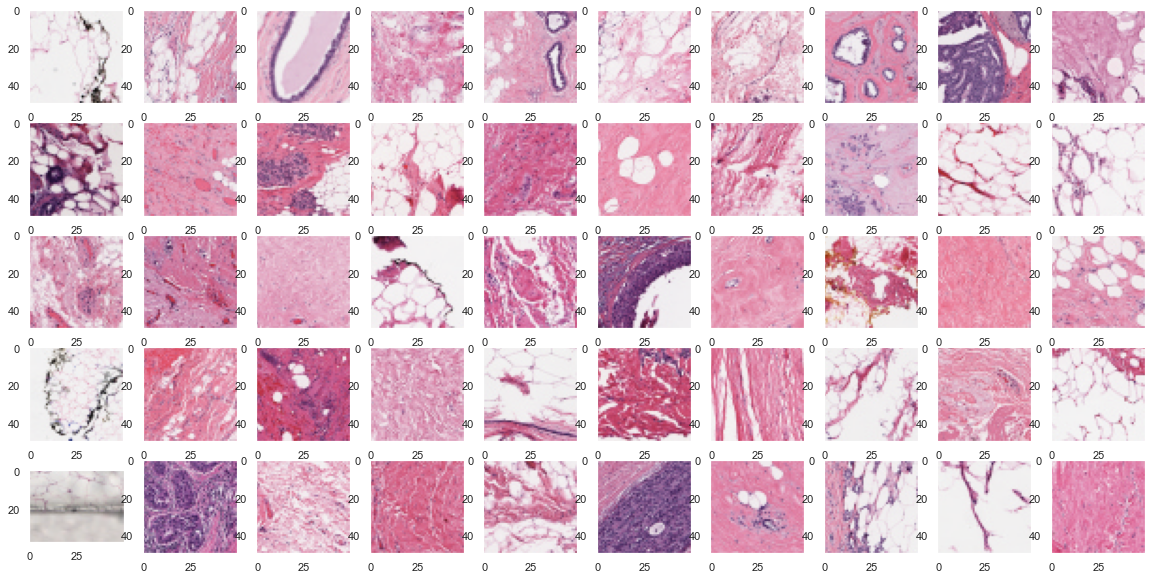

In [15]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

* Sometimes we can find artifacts or incomplete patches that have smaller size than 50x50 pixels. 
* Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?
* Though some of the healthy patches are very violet colored too!
* Would be very interesting to hear what criteria are important for a pathologist.
* I assume that the wholes in the tissue belong to the mammary ducts where the milk can flow through. 

## Visualising the breast tissue <a class="anchor" id="tissue"></a>

This part is a bit tricky! We have to extract all coordinates of image patches that are stored in the image names. Then we can use the coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [16]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [17]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()
example

x     y  target                                               path
0   1001  1001       0  breast-histopathology-images/IDC_regular_ps50_...
1   1001  1051       0  breast-histopathology-images/IDC_regular_ps50_...
2   1001  1101       0  breast-histopathology-images/IDC_regular_ps50_...
3   1001  1151       0  breast-histopathology-images/IDC_regular_ps50_...
4   1001  1201       0  breast-histopathology-images/IDC_regular_ps50_...
..   ...   ...     ...                                                ...
65   851   601       1  breast-histopathology-images/IDC_regular_ps50_...
66   851   651       1  breast-histopathology-images/IDC_regular_ps50_...
67   851   701       1  breast-histopathology-images/IDC_regular_ps50_...
68   851   751       1  breast-histopathology-images/IDC_regular_ps50_...
69   901   351       1  breast-histopathology-images/IDC_regular_ps50_...

[549 rows x 4 columns]

Ok, now we have the coordinates for each patch, its path to load the image and its target information.

### Binary target visualisation per tissue slice <a class="anchor" id="binarytissue"></a>

Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

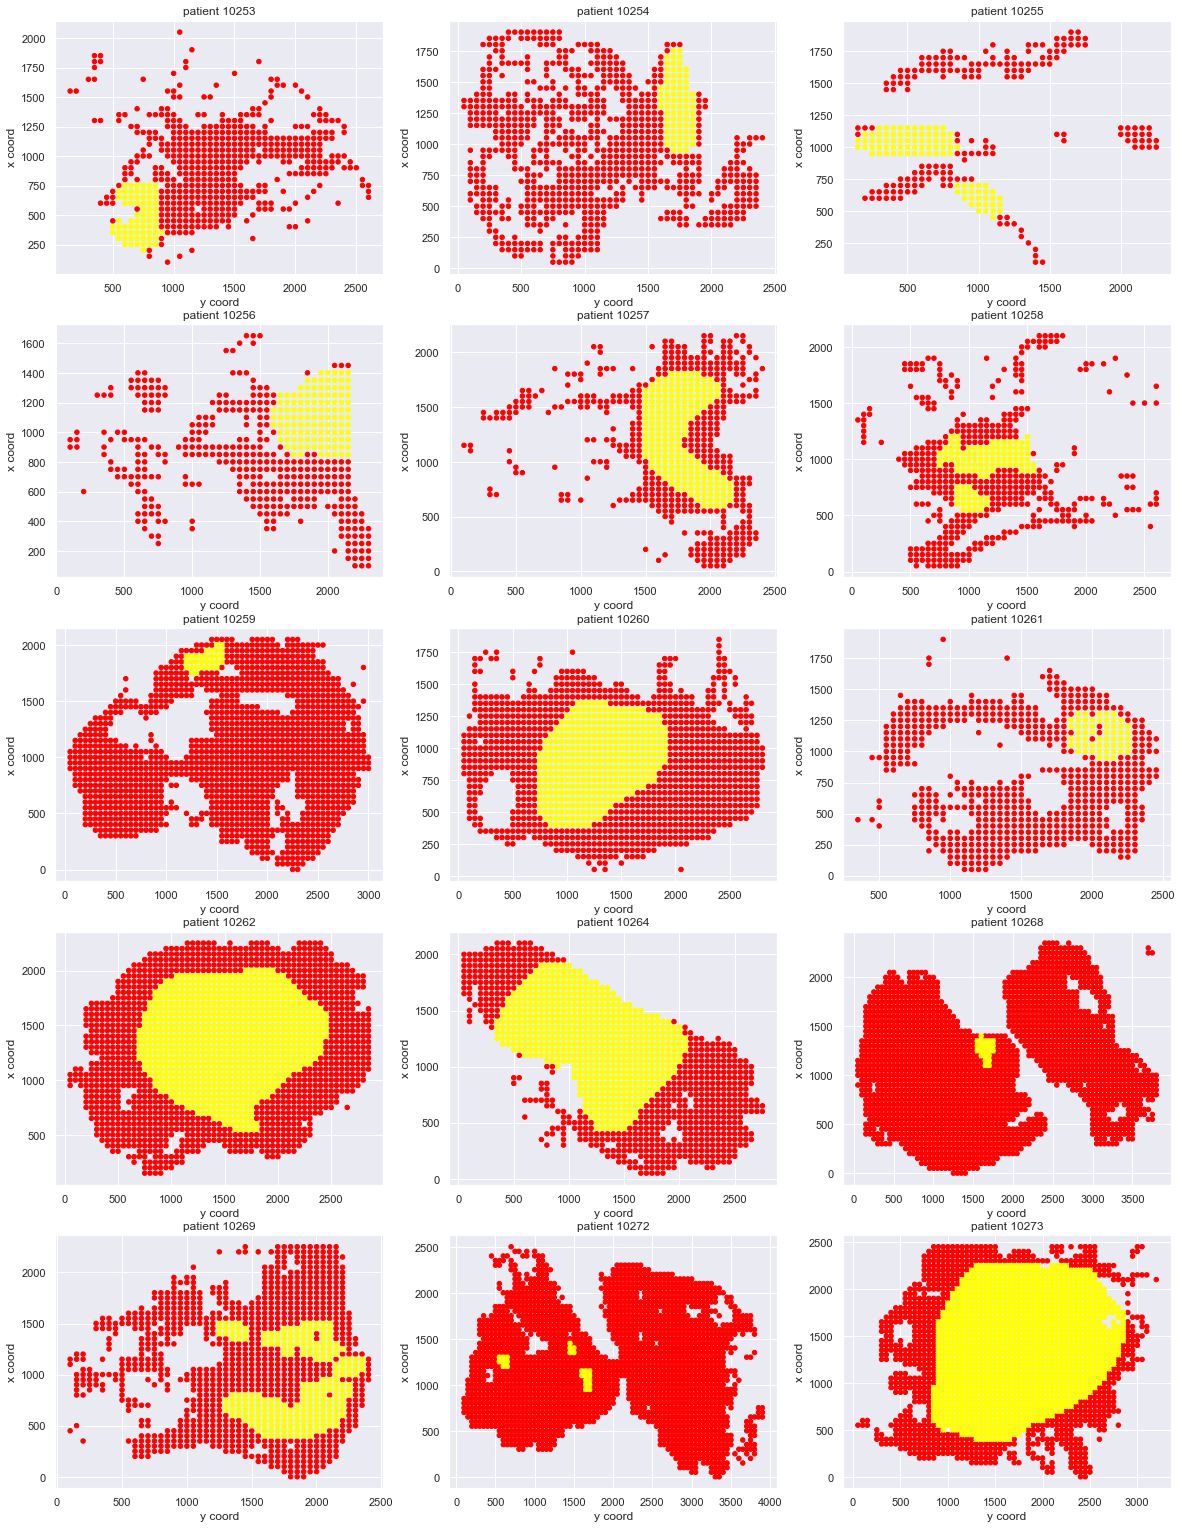

In [30]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="autumn", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights

* Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation. 
* Reading the paper (link!) that seems to be related to this data this could also be part of the preprocessing.

### Visualising the breast tissue images <a class="anchor" id="tissueimages"></a>

Ok, now it's time to go one step deeper with our EDA. Given the coordinates of image patches we could try to reconstruct the whole tissue image (not only the targets). 

In [33]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

Let's use an example patient with id 13616: 

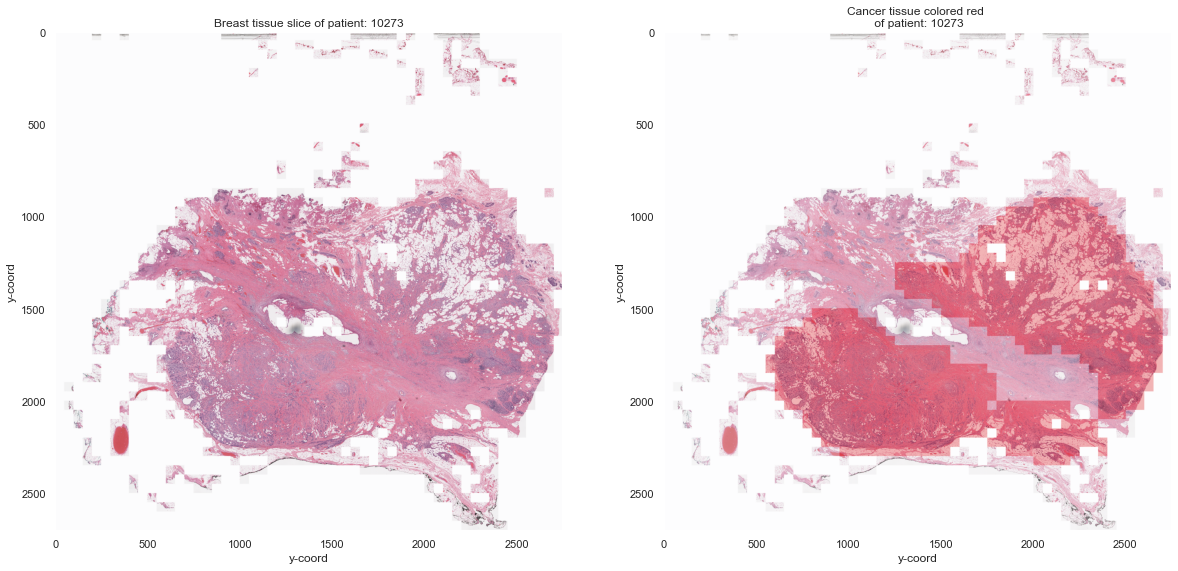

In [34]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

### Insights

* The tissue on the left is shown without target information.
* The image on the right shows the same tissue but cancer is stained with intensive red color. 
* Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color. 
* But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer! 

Sometimes it's not possible to load an image patch as the path is ill defined. But in our case, we were able to load them all:

In [35]:
broken_patches

[]

# Setting up the machine learning workflow <a class="anchor" id="workflow"></a>

## Settings <a class="anchor" id="ml_settings"></a>

In [36]:
BATCH_SIZE = 32
NUM_CLASSES = 2

OUTPUT_PATH = ""
MODEL_PATH = "breastcancermodel/"
LOSSES_PATH = "breastcancermodel/"

In [37]:
torch.manual_seed(0)
np.random.seed(0)

## Validation strategy <a class="anchor" id="validation"></a>

Let's start very simple by selecting 30 % of the patients as test data and the remaining 70 % for training and developing. This seems arbitrary and we should rethink this strategy in the next cycle of our datascience workflow. 

A better idea could be to cluster patients with dependence on the size of the tumor, the number of total patches and statistical quantities of area coverd by the patches. The reason behind that is that we would like to have test patients that cover a broad range of possible variations. Only then we can measure something like a generalisation performance.    

In [38]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


patient_id                                               path target
0           10253  breast-histopathology-images/IDC_regular_ps50_...      0
1           10253  breast-histopathology-images/IDC_regular_ps50_...      0
2           10253  breast-histopathology-images/IDC_regular_ps50_...      0
3           10253  breast-histopathology-images/IDC_regular_ps50_...      0
4           10253  breast-histopathology-images/IDC_regular_ps50_...      0
...           ...                                                ...    ...
277519       9383  breast-histopathology-images/IDC_regular_ps50_...      1
277520       9383  breast-histopathology-images/IDC_regular_ps50_...      1
277521       9383  breast-histopathology-images/IDC_regular_ps50_...      1
277522       9383  breast-histopathology-images/IDC_regular_ps50_...      1
277523       9383  breast-histopathology-images/IDC_regular_ps50_...      1

[277524 rows x 3 columns]

In [39]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

So far we can't stratify on the targets as we are splitting on patient ids. If we would like to include some target information we would need to create a feature that allows us to generate some balance. 

In [40]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


Now it's 70 % train and 15 % for dev and test.

In [41]:
print(len(train_ids), len(dev_ids), len(test_ids))

195 42 42


In [42]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

## Target distributions <a class="anchor" id="target_dists"></a>

Let's take a look at the target distribution difference of the datasets: 

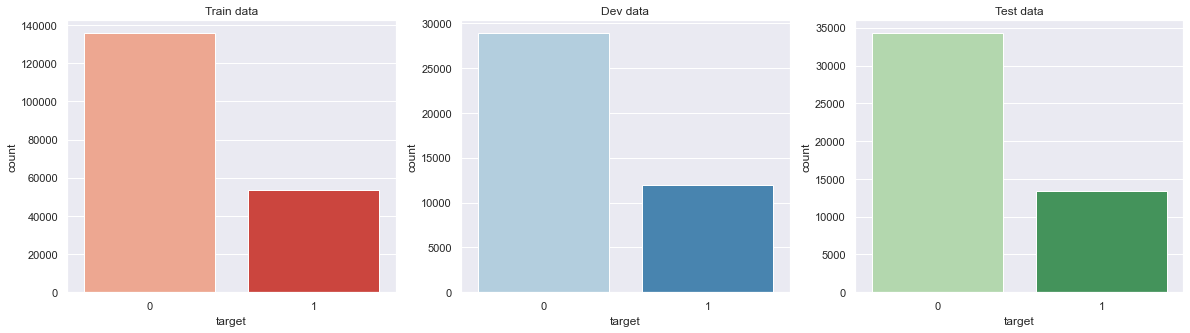

In [43]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(dev_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Dev data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

We can see that the test data has more cancer patches compared to healthy tissue patches than train or dev. We should keep this in mind!

## Creating pytorch image datasets <a class="anchor" id="image_datasets"></a>

It's often a good idea to start as simple as possible and to grow more complex while iterating through the solution. This way we prevent to build up models that are likely overfitted to the available data and we can find out useful ideas in a strategic manner instead of trying out every idea at random.

The simplest transformations we can do for each image are:

* resizing the images to the desired input shape
* performing horizontal and vertical flips

In our case the patches are of shape 50x50x3 and we could set this as our input shape. As CNNs are translational but not rotational invariant, it's a good idea to add flips during training. This way we increase the variety of our data in a meaningful way as each patch could be rotated as well on the tissue slice. As we are not looking at the whole tissue we are not loosing spatial connections between patches and it's not important that some neighboring patches are rotated in different directions.

In [44]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

Furthermore we need to create a dataset that loads an image patch of a patient, converts it to RGB, performs the augmentation if it's desired and returns the image, the target, the patient id and the image coordinates.

In [45]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = np.int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [46]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [47]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

Let's take a look at the augmentations:

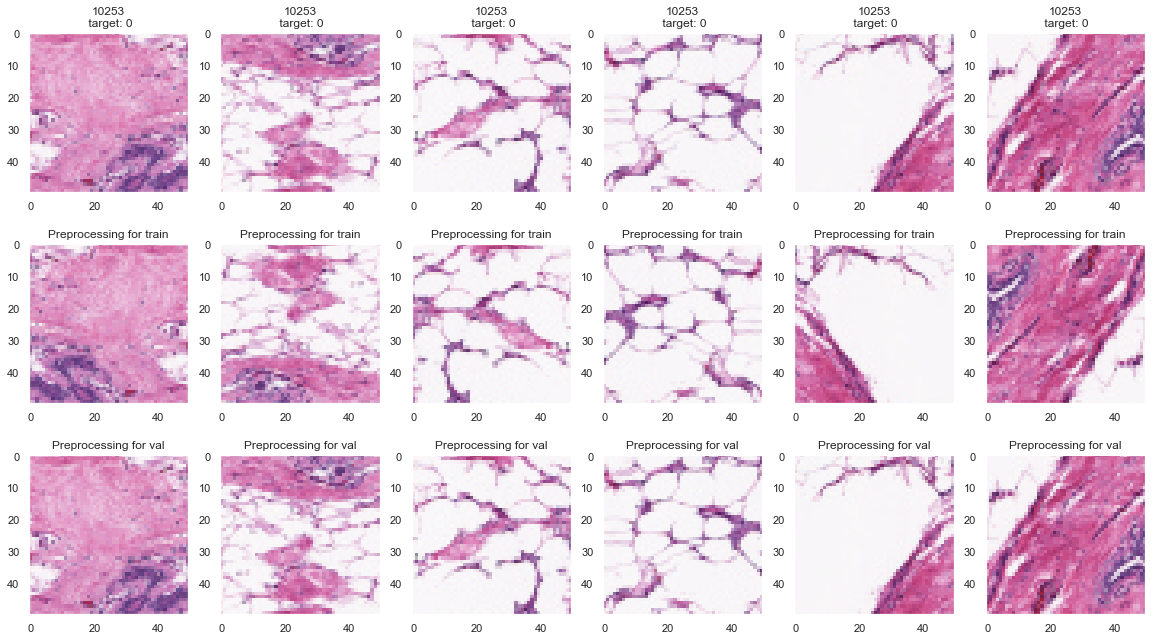

In [48]:
fig, ax = plt.subplots(3,6,figsize=(20,11))

train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    filepath = train_df.path.values[m]
    image = Image.open(filepath)
    ax[0,m].imshow(image)
    transformed_img = train_transform(image)
    ax[1,m].imshow(transformed_img)
    ax[2,m].imshow(val_transform(image))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[2,m].grid(False)
    ax[0,m].set_title(train_df.patient_id.values[m] + "\n target: " + train_df.target.values[m])
    ax[1,m].set_title("Preprocessing for train")
    ax[2,m].set_title("Preprocessing for val")

For validation we have only used the image resizing.

## Creating pytorch dataloaders <a class="anchor" id="dataloaders"></a>

As the gradients for each learning step are computed over batches we benefit from shuffling the training data after each epoch. This way each batch is composed differently and we don't start to learn for specific sequences of images. For validation and training we drop the last batch that often consists less images than the batch size.

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [50]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [51]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

5911 1273 1489


## Defining the model structure <a class="anchor" id="model_structure"></a>

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Our dataset is very small and we should be afraid of overfitting to our patients. For this reason it can be a good idea to use transfer learning with a pretrained CNN. This way we benefit from the fact that the first layers of a pretrained CNN extract basic features like edges for example and only last layers contain very problem specific features. Again our policy is to start simple by using a small network like resnet18:

In [53]:
model = torchvision.models.resnet18(pretrained=False)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


## Setting up the loss function <a class="anchor" id="loss"></a>

The task to predict the presence of inasive ductal carcinoma given a tissue patch is a binary classification. A common loss for this problem is the binary cross entropy function. Using it we could only use one single output neuron to make predictions. As I like to compute the f1-score during training and prediction and I need to compute false and true positives/negatives in a simple manner I will use the cross entropy loss with K=2 output neurons or 2 classes that can be hot (1) or cold (0) with $\sum_{k}y_{nk}=1$:

$$ L = -\sum_{n=1}^{N} \sum_{k=1}^{K=2} w_{k} \cdot t_{n,k} \cdot \ln (y_{nk})$$ 

The $w_{k}$ are used to weight the positive and negative classes such that we are able to deal with the class imbalance. In our case we have much more negative (healthy) patches than those with cancer. To deal with this imbalance we like to increase the impact of the gradients of positive cases during training and we can do so with a higher weight than for the negative cases.

In [54]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6973, 1.7673])


In [55]:
train_df.target.unique()

array(['0', '1'], dtype=object)

You can see that class 1 (positive cancer) has a higher weight.

In [56]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Selecting an evaluation metric <a class="anchor" id="e_metric"></a>

The percentage of correct predictions (accuracy score) is not a good evaluation metric for imbalanced target distributions. Imagine our model would predict "no cancer" for all patches. Even then we still obtain a accuracy score higher than 0.5 and we have no further insights. 


### The f1-score

A better choice is the f1-score that is defined as the harmonic mean of precision and recall:

$$ f_{1} = \frac{2}{\frac{1}{recall} + \frac{1}{precision}} $$

In contrast to the arithmetic mean it is shifted towards small outiers but not influenced strongly by large ones. Hence if either the recall or the precision is small, the f1-score will then tend towards the smaller value. Let's pick an example with $recall=0.1$ and $precision=0.6$:

$$ f_{1} = \frac{2}{\frac{1}{0.1} + \frac{1}{0.6}} = \frac{2}{\frac{10}{1} + \frac{10}{6}} = \frac{2 \cdot 6}{70} = \frac{12}{70} = 0.1714$$

You can see that the $f1-score=0.1714$ is then shifted towards the smaller value of the recall and not close to the arithmetic mean of $\mu=0.35$.

### Precision and recall

To fully understand the f1-score we first need to grasp precision and recall. :-) To be honest... I always have to look it up:

$$ recall = \frac{TruePositives}{TruePositives + FalsePositives} $$

Imagine our model would predict "cancer" all the time. Then we would have the maximum number of true positives but also a very high number of false positives that decreases the recall to some baseline value. In contrast if our model would always predict "no cancer" we would have no true positives and our recall equals zero. For this reason one can say that the recall answers: **"How many selected cases are positive?"**

$$ precision = \frac{TruePositives}{TruePositives + FalseNegatives} $$

**How many positive cases are selected?**

In [57]:
def f1_score(preds, targets):
    
    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)
    
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

## Building the training loop <a class="anchor" id="train_loop"></a>

In [58]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)
                        
                        #loss += l2_reg
            
                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step() 
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)
                            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                      
     
                counter += 1
                
                
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

## Searching for an optimal cyclical learning rate <a class="anchor" id="lr_cycle_optima"></a>

The learning rate is one of the most important hyperparameters for tuning neural networks. A rate that is too high will lead to jumps to higher values in the training loss during optimization. If it's too small the learning process is too slow and will probably stop too early in the case we have defined a minimum required loss change. Take a look at the paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).

In [59]:
start_lr = 1e-6
end_lr = 0.1

In [60]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations 
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")
    
    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [61]:
import math

if find_learning_rate:
    lr_find_epochs=1
    optimizer = optim.SGD(model.fc.parameters(), start_lr)
    scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs*len(train_dataloader))
    results = train_loop(model, criterion, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
    lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]
    
    find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
    find_lr_df.loc[:, "lr"] = lr_find_lr
    find_lr_df.to_csv("learning_rate_search.csv", index=False)
else:
    find_lr_df = pd.read_csv(MODEL_PATH + "learning_rate_search.csv")

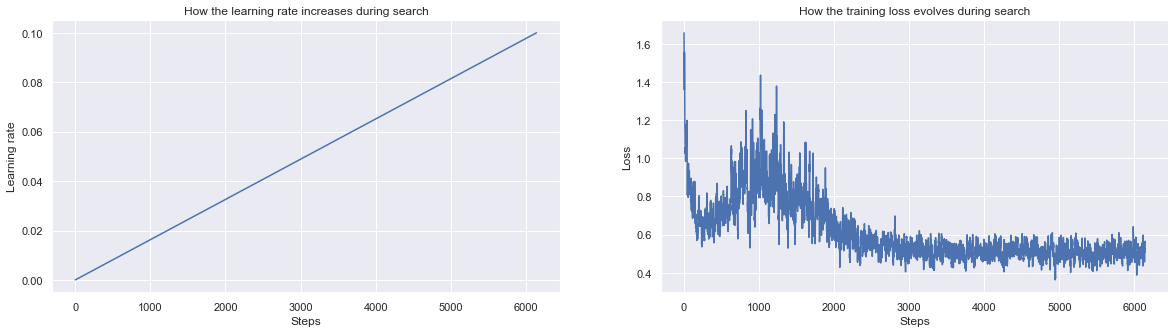

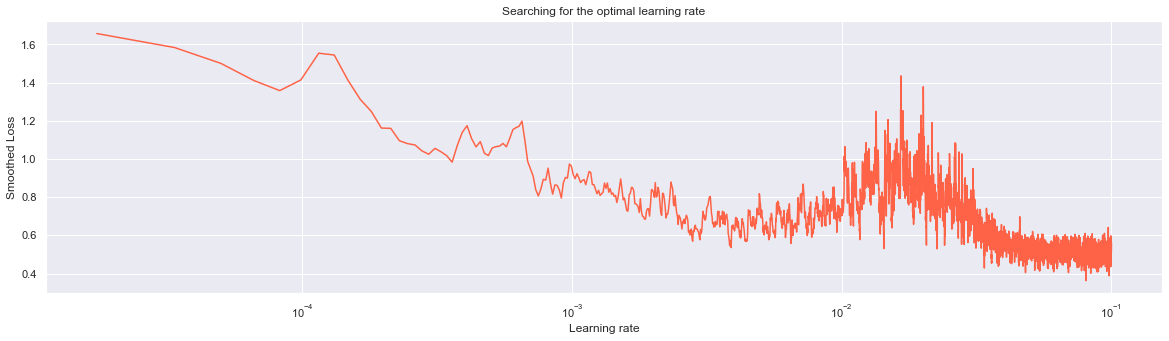

In [62]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df["smoothed loss"].values)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Learning rate")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss");
ax[0].set_title("How the learning rate increases during search")
ax[1].set_title("How the training loss evolves during search")

plt.figure(figsize=(20,5))
plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Smoothed Loss")
plt.title("Searching for the optimal learning rate");

### Insights

* The loss drops right from the start but increases after  values higher than 0.005. 
* Consequently we can set the minimum learning rate to 1e-6 and the maximum to 0.005.

In [63]:
start_lr = 1e-6
end_lr = 0.006

## Performing the training or loading results <a class="anchor" id="run"></a>

In [64]:
if run_training:
    NUM_EPOCHS = 30
    optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
    scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*NUM_EPOCHS)
    results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
    model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]
    
    if device == "cpu":
        OUTPUT_PATH += ".pth"
    else:
        OUTPUT_PATH += "_cuda.pth"
        
    torch.save(model.state_dict(), OUTPUT_PATH)
    
    losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
    losses_df.loc[:, "dev"] = loss_dict["dev"]
    losses_df.loc[:, "test"] = loss_dict["test"]
    losses_df.to_csv("losses_breastcancer.csv", index=False)
    
    running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
    running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
    running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
    running_losses_df.to_csv("running_losses_breastcancer.csv", index=False)
else:
    if device == "cpu":
        load_path = MODEL_PATH + ".pth"
    else:
        load_path = MODEL_PATH + "_cuda.pth"
    model.load_state_dict(torch.load(load_path, map_location='cpu'))
    model.eval()
    
    losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancer.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancer.csv")

# Exploring results and errors <a class="anchor" id="error_analysis"></a>

## Loss convergence <a class="anchor" id="losses"></a>

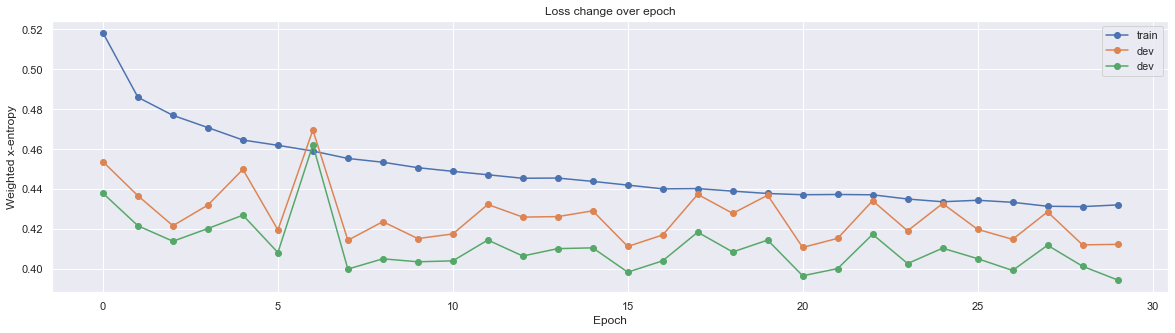

In [65]:
plt.figure(figsize=(20,5))

plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="dev")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epoch")
plt.legend();

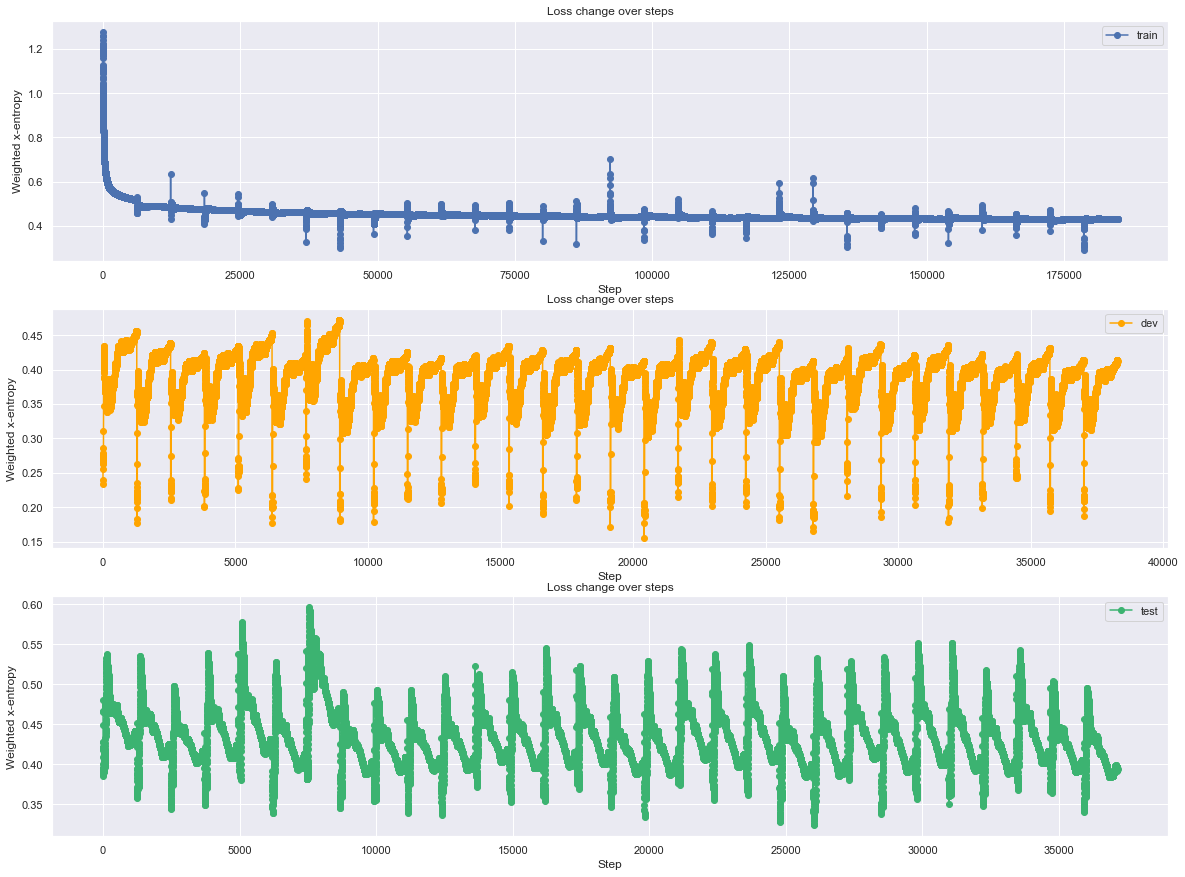

In [66]:
fig, ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(running_losses_df["train"], '-o', label="train")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Weighted x-entropy")
ax[0].set_title("Loss change over steps")
ax[0].legend();

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend();

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend();

## The probability landscape of invasive ductal carcinoma <a class="anchor" id="landscape"></a>

In [67]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]
            
    predictions_df = predictions_df.dropna()
    return predictions_df

In [68]:
if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")
    
    dev_predictions.to_csv("dev_predictions.csv", index=False)
    test_predictions.to_csv("test_predictions.csv", index=False)
    
else:
    
    dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")
    
    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

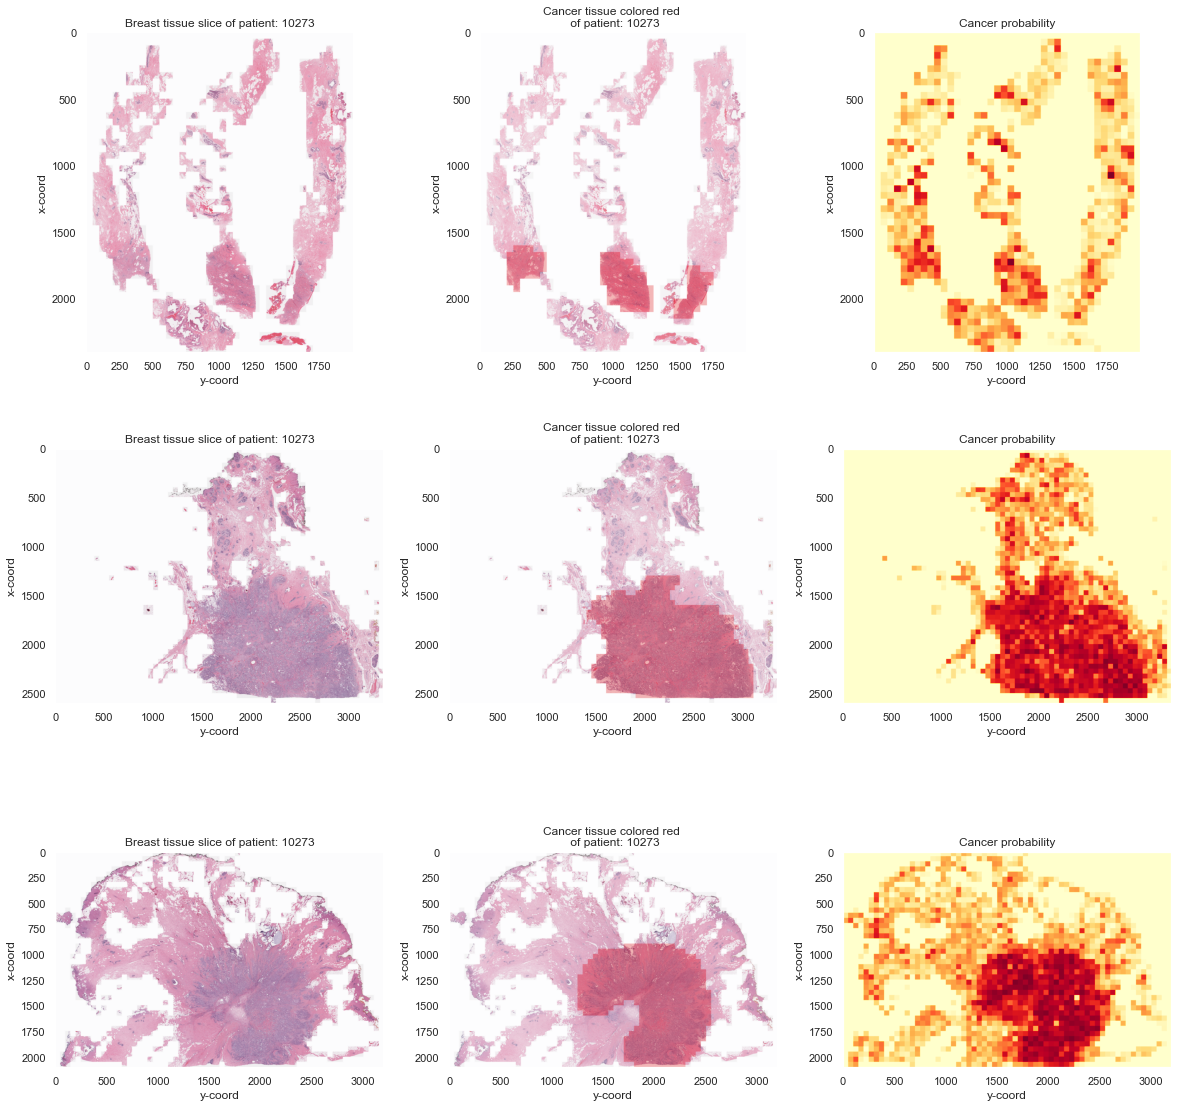

In [69]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

for n in range(3):

    idx = dev_predictions.patient_id.unique()[n]
    grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)


    ax[n, 0].imshow(grid, alpha=0.9)
    ax[n, 1].imshow(mask, alpha=0.8)
    ax[n, 1].imshow(grid, alpha=0.7)
    ax[n, 2].imshow(mask_proba[:,:,0], cmap="YlOrRd")

    for m in range(3):
        ax[n, m].set_xlabel("y-coord")
        ax[n, m].set_ylabel("x-coord")
        ax[n, m].grid(False)
        
    ax[n, 0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[n, 1].set_title("Cancer tissue colored red \n of patient: " + patient_id);
    ax[n, 2].set_title("Cancer probability");

## Going into details

### TODO

* Number of correct classifications per patient compared to cancer/tissue size.
* Confusion matrix
* Exploring very bad results. 

In [70]:
dev_predictions.head()

true  predicted     proba       x       y patient_id
0     0          0  0.003411   501.0  2001.0       9135
1     0          0  0.111403  1251.0   501.0       9135
2     0          0  0.234970   351.0   351.0       9135
3     0          0  0.599228   351.0  1051.0       9135
4     0          0  0.096663  1401.0   151.0       9135

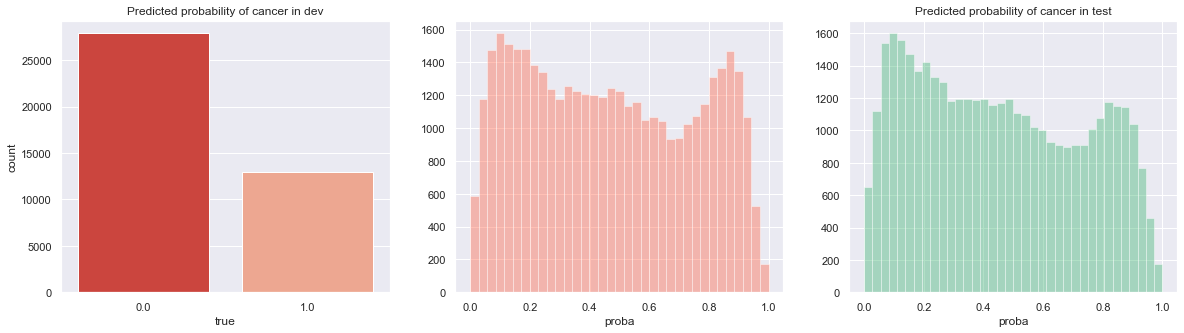

In [71]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(dev_predictions.true.astype(np.float), ax=ax[0], palette="Reds_r")
ax[0].set_title("Target counts of dev data");
sns.distplot(dev_predictions.proba.astype(np.float), ax=ax[1], kde=False, color="tomato")
ax[0].set_title("Predicted probability of cancer in dev");
sns.distplot(test_predictions.proba.astype(np.float), ax=ax[2], kde=False, color="mediumseagreen");
ax[2].set_title("Predicted probability of cancer in test");

In [77]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df


Confusion Matrix - Dev (Validation) 

                  predicted no cancer  predicted cancer
actual no cancer             0.833817          0.166183
actual cancer                0.176798          0.823202

                  precision    recall  f1-score   support

actual no cancer       0.91      0.83      0.87     27885
   actual cancer       0.70      0.82      0.75     12947

        accuracy                           0.83     40832
       macro avg       0.80      0.83      0.81     40832
    weighted avg       0.84      0.83      0.83     40832


Balanced Accuracy score: 0.8285098754153064

AUC score:
0.8955620948616059


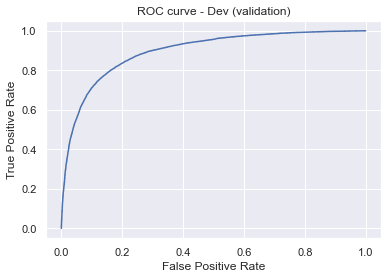

In [78]:
print('Confusion Matrix - Dev (Validation) \n')

conf_matrix_dev = get_confusion_matrix(dev_predictions.true, dev_predictions.predicted)
print(conf_matrix_dev)
# print(f1_score(dev_predictions.predicted, dev_predictions.true))

print('')
from sklearn.metrics import classification_report,balanced_accuracy_score, roc_curve,roc_auc_score
print(classification_report(dev_predictions.true, dev_predictions.predicted, target_names=['actual no cancer', 'actual cancer']))

print('\nBalanced Accuracy score: ' + str( balanced_accuracy_score(dev_predictions.true, dev_predictions.predicted)))

fpr, tpr, thresholds = roc_curve(dev_predictions.true, dev_predictions.proba)


fig, ax = plt.subplots(1,1)
ax.plot(fpr,tpr); ax.set_xlabel('False Positive Rate') ; ax.set_ylabel('True Positive Rate'); plt.title('ROC curve - Dev (validation)')
# print(thresholds)

auc_score_dev = roc_auc_score(dev_predictions.true, dev_predictions.proba)
print('\nAUC score:')
print(auc_score_dev)

In [79]:
print(test_predictions)

       true  predicted     proba       x       y  patient_id
0         0          0  0.128713  1201.0  2401.0       12906
1         0          0  0.347586   151.0  1001.0       12906
2         0          0  0.175564  1301.0  1251.0       12906
3         0          0  0.103502  1351.0   551.0       12906
4         0          0  0.224504   601.0  1551.0       12906
...     ...        ...       ...     ...     ...         ...
39600     1          1  0.680131  1651.0   701.0       14304
39601     1          1  0.814124  1201.0   851.0       14304
39602     1          0  0.551968  1201.0   901.0       14304
39603     1          1  0.894965   851.0   101.0       14304
39604     1          1  0.948164  1401.0  1151.0       14304

[39605 rows x 6 columns]


Confusion Matrix - Test set 

                  predicted no cancer  predicted cancer
actual no cancer             0.854794          0.145206
actual cancer                0.213635          0.786365

                  precision    recall  f1-score   support

actual no cancer       0.90      0.85      0.88     27313
   actual cancer       0.71      0.79      0.75     12292

        accuracy                           0.83     39605
       macro avg       0.80      0.82      0.81     39605
    weighted avg       0.84      0.83      0.84     39605


Balanced Accuracy score: 0.8205797678808686

AUC score:
0.8917535686772649


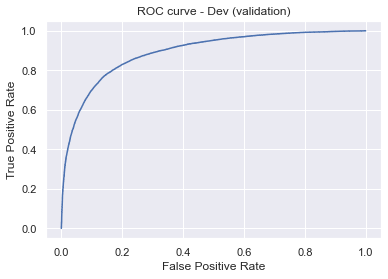

In [80]:
print("Confusion Matrix - Test set \n")
conf_matrix_test = get_confusion_matrix(test_predictions.true, test_predictions.predicted)
print(conf_matrix_test)
# print(f1_score(test_predictions.predicted, test_predictions.true))

print('')
from sklearn.metrics import classification_report, balanced_accuracy_score

print(classification_report(test_predictions.true, test_predictions.predicted, target_names=['actual no cancer', 'actual cancer']))

print('\nBalanced Accuracy score: ' + str(balanced_accuracy_score(test_predictions.true, test_predictions.predicted)))


fpr, tpr, thresholds = roc_curve(test_predictions.true, test_predictions.proba)


fig, ax = plt.subplots(1,1)
ax.plot(fpr,tpr); ax.set_xlabel('False Positive Rate') ; ax.set_ylabel('True Positive Rate'); plt.title('ROC curve - Dev (validation)')
# print(thresholds)

auc_score_dev = roc_auc_score(test_predictions.true, test_predictions.proba)
print('\nAUC score:')
print(auc_score_dev)